# First we load some UCI data from the UCI Repository

In [2]:
datasetname = "ionosphere"

using UCIMLRepo
dataframe = ucirepodata("ionosphere")

# extract data and ignore labels
X = float(convert(Array, dataframe)[1:34, :]);

fetching from the following url : http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data


## Normalize data and print some simple statistics

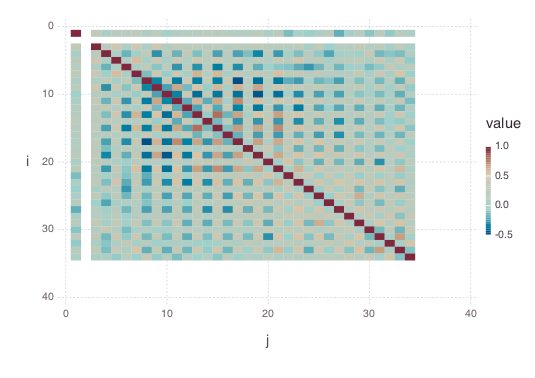

In [3]:
using StatsBase

X = X .- mean(X, 2)
X = X ./ (std(X, 2) + 1e-10)

covariance = cov(X')

using Gadfly

spy(covariance)

# Define intial State

In [4]:
using SPN, BNP

In [5]:
# Data
(D, N) = size(X)

# G0
μ0 = vec( mean(X, 2) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D) * 10

G0 = GaussianWishart(μ0, κ0, ν0, Ψ)

# define G0 for mirrored SPN rooted at mirrorSPN
μ0 = vec( mean(X, 1) )
κ0 = 1.0
ν0 = convert(Float64, N)
Ψ = eye(N) * 10

G0Mirror = GaussianWishart(μ0, κ0, ν0, Ψ)

# initial state
root = SumNode(0, scope = collect(1:D))
add!(root, MultivariateNode{ConjugatePostDistribution}(BNP.add_data(G0, X), collect(1:D)))

println("finished set up of intial state...")

finished set up of intial state...


## define learning algorithm for infinite SPNs

In [6]:
# preperation steps

# create initial assignment
assign = Assignments(N)
for i in collect(1:N)
    assign!(assign, i, root.children[1])
end

add!(assign, root)
increment!(assign, root, i = N)

add!(assign, root.children[1])
increment!(assign, root.children[1], i = N)

# single Gibbs step
println(" * Gibbs sweep in instance space")

for id in randperm(N)

	x = X[:, id]

	kdists = assign[id]

	for dist in kdists
		# - remove "random" data point
		decrement!(assign, dist)
		remove_data!(dist.dist, x[dist.scope,:])
	end

	# get k's

	toporder = SPN.order(root)

	llhval = Dict{SPNNode, Array{Float64}}()
	kvals = Dict{SPNNode, Int}()

	for node in toporder

			(llh, newk) = evalWithK(node, x, llhval, assign, G0)

			# always open a new table
			if id % 10 == 0
				newk = 2
			end

			llhval[node] = llh
			kvals[node] = newk
	end

	# assign datum to
	recurseCondK!(root, kvals, x, id, assign, G0)

end

println(" * Extend SPN with Product")

extend!(root, assign)

println(" * Gibbs on mirror SPN")

toporder = SPN.order(root)

println(" * Clean up")

# clean up
for node in toporder
    # remove if no data points assigned
    if assign(node) == 0
        killChild!(node, assign)
    end
end

println(" * parallel Gibbs sweeps on variables.")

# for each product node
for child in root.children

	if isa(child, ProductNode)

		toporder = SPN.order(child)

		assignMirror = SPN.Assignments(D)
		assignMirror.S = assign.S

		for node in toporder

			if isa(node, SPN.Leaf)
				for i in node.scope
					SPN.assign!(assignMirror, i, node)
				end
			end
		end

		# mirror all Leafs
		for node in toporder

			if isa(node, Leaf)
				SPN.mirror!(node, assign, X, G0Mirror)
			end

		end

		for id in randperm(D)

			x = X[id, :]'

			kdists = assignMirror[id]

			for dist in kdists
				# - remove data point
				SPN.decrement!(assignMirror, dist)
				remove_data!(dist.dist, x[dist.scope,:])

			end
            
            toporder = SPN.order(child)

			llhval = Dict{SPNNode, Array{Float64}}()
			kvals = Dict{SPNNode, Int}()

			for node in toporder
					(llh, newk) = SPN.evalWithK(node, x, llhval, assignMirror, G0Mirror, mirror = true)

					llhval[node] = llh
					kvals[node] = newk
			end

			# assign datum to
			SPN.recurseCondK!(child, kvals, x, id, assignMirror, G0Mirror)

		end

		for node in toporder

			if isa(node, SPN.Leaf)
				SPN.mirror!(node, assignMirror, X, G0, mirrored = true)
			end

		end

	end

end


 * Gibbs sweep in instance space
 * Extend SPN with Product
 * Gibbs on mirror SPN
 * Clean up


LoadError: LoadError: DomainError:
while loading In[6], in expression starting on line 76

 * parallel Gibbs sweeps on variables.
